In [2]:
# === 1. Install & Import ===
!pip install -q transformers datasets

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import os
import gc
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# === 2. Teacher model setup (CPU only) ===
teacher_id = "openlm-research/open_llama_3b_v2"
teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_id, trust_remote_code=True)
teacher_model = AutoModelForCausalLM.from_pretrained(teacher_id, trust_remote_code=True, torch_dtype=torch.float16).to(device).eval()

# === 3. Define prompt formatter ===
def format_prompt(example, task):
    if task == "summarization":
        return f"Summarize:\n{example['article']}\n\nSummary:"
    elif task == "qa":
        return f"Context: {example['context']}\nQuestion: {example['question']}\nAnswer:"
    elif task == "paraphrase":
        return f"Paraphrase:\n{example['questions']['text']}\n\nParaphrase:"
    return ""

# === 4. Define task dataset loaders ===
task_data = {
    "summarization": load_dataset("cnn_dailymail", "3.0.0", split="train[:300]"),
    "qa": load_dataset("squad_v2", split="train[:300]"),
    "paraphrase": load_dataset("quora", split="train[:300]",trust_remote_code=True).filter(lambda x: x["is_duplicate"])
}


# === 5. Save logits for each task ===
os.makedirs("teacher_logits", exist_ok=True)

for task, dataset in task_data.items():
    print(f"\n🧠 Extracting teacher logits for: {task}")
    save_dir = f"teacher_logits/{task}"
    os.makedirs(save_dir, exist_ok=True)

    for i, example in enumerate(tqdm(dataset)):
        try:
            prompt = format_prompt(example, task)
            inputs = teacher_tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            with torch.no_grad():
                logits = teacher_model(**inputs).logits[:, :-1, :]

            # Save each sample as its own .pt file
            torch.save({
                "input_ids": inputs["input_ids"][:, :-1].cpu(),
                "attention_mask": inputs["attention_mask"][:, :-1].cpu(),
                "logits": logits.cpu().half()  # reduce memory
            }, f"{save_dir}/{i:05d}.pt")

            # Cleanup
            del inputs, logits
            torch.cuda.empty_cache()
            gc.collect()

        except Exception as e:
            print(f"❌ Failed on sample {i}: {e}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.3.3.83 which is incompatible.
torch 2.5.1+cu124 requires nvidia-curand-cu12==10.3.5.147; platform_system == "Linux" and platform_machin

tokenizer_config.json:   0%|          | 0.00/593 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/512k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/330 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggin

config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

2025-05-10 06:52:15.196104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746859935.434565      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746859935.506508      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/6.85G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.85G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/5.69k [00:00<?, ?B/s]

quora.py:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/404290 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]


🧠 Extracting teacher logits for: summarization


100%|██████████| 300/300 [04:46<00:00,  1.05it/s]



🧠 Extracting teacher logits for: qa


100%|██████████| 300/300 [03:37<00:00,  1.38it/s]



🧠 Extracting teacher logits for: paraphrase


100%|██████████| 116/116 [00:53<00:00,  2.18it/s]


In [3]:
del teacher_model
torch.cuda.empty_cache()
import gc
gc.collect()

0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have rmm-cu12 25.2.0 which is incompatible.


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]


📘 Distilling student for task: summarization
✅ Found 300 samples in teacher_logits/summarization

🌀 Epoch 1


  0%|          | 0/300 [00:00<?, ?it/s]/tmp/ipykernel_19/4165389375.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  entry = torch.load(fpath)
100%|██████████| 300/300 [

✅ Avg loss epoch 1: 4915.0983

🌀 Epoch 2


100%|██████████| 300/300 [04:09<00:00,  1.20it/s]


✅ Avg loss epoch 2: 4426.7750

🌀 Epoch 3


100%|██████████| 300/300 [04:02<00:00,  1.24it/s]


✅ Avg loss epoch 3: 4302.6333
📦 Saved to student_lora_mixture_summarization


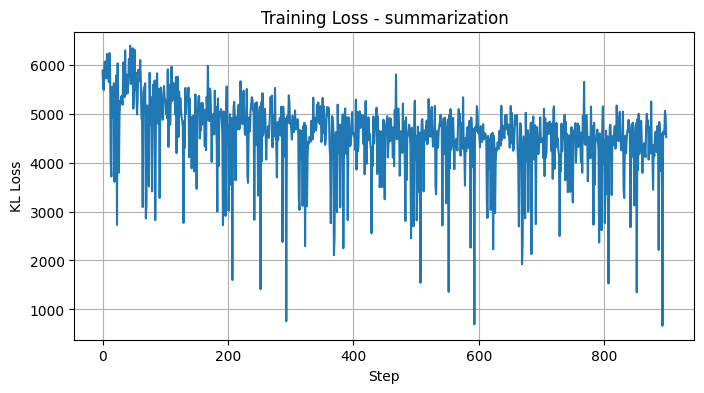


📘 Distilling student for task: qa
✅ Found 300 samples in teacher_logits/qa

🌀 Epoch 1


100%|██████████| 300/300 [03:30<00:00,  1.42it/s]


✅ Avg loss epoch 1: 2855.3067

🌀 Epoch 2


100%|██████████| 300/300 [03:16<00:00,  1.52it/s]


✅ Avg loss epoch 2: 2448.4317

🌀 Epoch 3


100%|██████████| 300/300 [03:10<00:00,  1.58it/s]


✅ Avg loss epoch 3: 2309.3417
📦 Saved to student_lora_mixture_qa


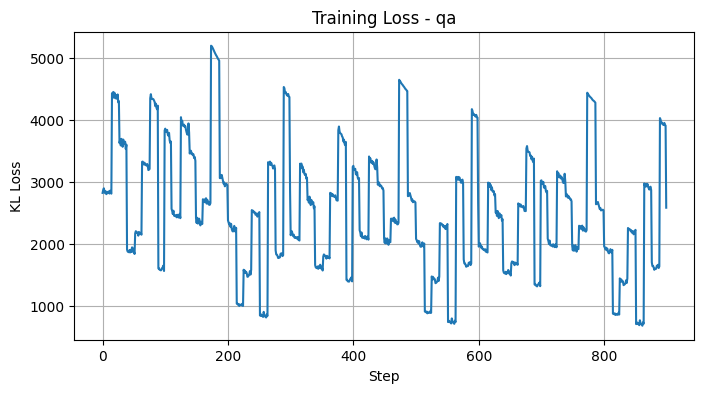


📘 Distilling student for task: paraphrase
✅ Found 116 samples in teacher_logits/paraphrase

🌀 Epoch 1


100%|██████████| 116/116 [00:56<00:00,  2.04it/s]


✅ Avg loss epoch 1: 302.0625

🌀 Epoch 2


100%|██████████| 116/116 [00:56<00:00,  2.07it/s]


✅ Avg loss epoch 2: 260.4138

🌀 Epoch 3


100%|██████████| 116/116 [00:56<00:00,  2.07it/s]


✅ Avg loss epoch 3: 244.5124
📦 Saved to student_lora_mixture_paraphrase


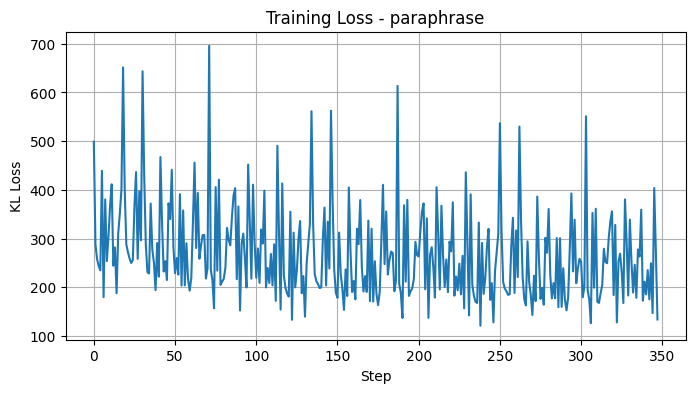

In [4]:
# === 1. Install & Import ===
!pip install -q peft transformers torch accelerate

import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import get_peft_model, LoraConfig, TaskType
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc
import glob

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 2. Student base + tokenizer ===
student_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(student_id, trust_remote_code=True)
base_model = AutoModelForCausalLM.from_pretrained(
    student_id, trust_remote_code=True, torch_dtype=torch.float16
).to(device)

# === 3. Task list ===
TASKS = ["summarization", "qa", "paraphrase"]

# === 4. LoRA distillation per task ===
for task in TASKS:
    print(f"\n📘 Distilling student for task: {task}")
    student = get_peft_model(base_model, LoraConfig(
        r=8, lora_alpha=16, target_modules=["q_proj", "v_proj"],
        lora_dropout=0.1, bias="none", task_type=TaskType.CAUSAL_LM
    ))
    student.train()
    optimizer = torch.optim.AdamW(student.parameters(), lr=5e-5)

    # === Load per-sample files ===
    data_dir = f"teacher_logits/{task}"
    file_list = sorted(glob.glob(f"{data_dir}/*.pt"))
    print(f"✅ Found {len(file_list)} samples in {data_dir}")

    # === Training loop ===
    loss_curve = []
    for epoch in range(3):
        print(f"\n🌀 Epoch {epoch+1}")
        epoch_loss = 0.0

        for fpath in tqdm(file_list):
            try:
                entry = torch.load(fpath)

                input_ids = entry["input_ids"].to(device)
                attention_mask = entry["attention_mask"].to(device)
                teacher_logits = entry["logits"].to(device)

                student_logits = student(input_ids=input_ids, attention_mask=attention_mask).logits

                min_len = min(student_logits.shape[1], teacher_logits.shape[1])
                loss = F.kl_div(
                    F.log_softmax(student_logits[:, :min_len, :] / 2.0, dim=-1),
                    F.softmax(teacher_logits[:, :min_len, :] / 2.0, dim=-1),
                    reduction="batchmean"
                ) * 4.0

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                loss_val = loss.item()
                epoch_loss += loss_val
                loss_curve.append(loss_val)

                del input_ids, attention_mask, teacher_logits, student_logits, loss, entry
                torch.cuda.empty_cache()
                gc.collect()

            except Exception as e:
                print(f"❌ Failed on {fpath}: {e}")
                torch.cuda.empty_cache()
                gc.collect()
                continue

        print(f"✅ Avg loss epoch {epoch+1}: {epoch_loss / len(file_list):.4f}")

    # === Save LoRA adapter ===
    out_dir = f"student_lora_mixture_{task}"
    student.save_pretrained(out_dir)
    print(f"📦 Saved to {out_dir}")

    # === Plot loss ===
    plt.figure(figsize=(8, 4))
    plt.plot(loss_curve, label=task)
    plt.title(f"Training Loss - {task}")
    plt.xlabel("Step")
    plt.ylabel("KL Loss")
    plt.grid(True)
    plt.show()

    del student
    torch.cuda.empty_cache()
    gc.collect()

In [5]:
# === 1. Install & Import ===
!pip install -q peft transformers datasets accelerate

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
from datasets import load_dataset
import json
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 2. Load Base Student + Tokenizer ===
student_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(student_id, trust_remote_code=True)
base_model = AutoModelForCausalLM.from_pretrained(student_id, torch_dtype=torch.float16).to(device)
base_model.eval()

# === 3. Helper Functions ===
def generate_output(model, prompt, max_new_tokens=128):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).to(device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=max_new_tokens)
    torch.cuda.empty_cache()
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def clean_prediction(pred, task):
    if task == "summarization":
        return pred.split("Summary:")[-1].strip() if "Summary:" in pred else pred.strip()
    elif task == "qa":
        return pred.split("Answer:")[-1].strip() if "Answer:" in pred else pred.strip()
    elif task == "paraphrase":
        return pred.replace("Paraphrase:", "").strip()
    return pred.strip()

# === 4. Summarization ===
summarization_model = PeftModel.from_pretrained(base_model, "student_lora_mixture_summarization").to(device).eval()
summarization_data = load_dataset("cnn_dailymail", "3.0.0", split="test[:100]")

summarization_outputs = []
for item in tqdm(summarization_data, desc="Summarization"):
    prompt = f"Summarize the following article:\n\n{item['article']}\n\nSummary:"
    output = generate_output(summarization_model, prompt)
    summarization_outputs.append({
        "id": item["id"],
        "reference": item["highlights"],
        "prediction": output,
        "clean_prediction": clean_prediction(output, "summarization")
    })

with open("student_summarization_outputs.json", "w") as f:
    json.dump(summarization_outputs, f, indent=2)

del summarization_model
torch.cuda.empty_cache()

# === 5. Question Answering ===
qa_model = PeftModel.from_pretrained(base_model, "student_lora_mixture_qa").to(device).eval()
qa_data = load_dataset("squad_v2", split="validation[:100]")

qa_outputs = []
for item in tqdm(qa_data, desc="QA"):
    prompt = (
        f"Context: {item['context']}\n"
        f"Question: {item['question']}\n"
        f"Answer:"
    )
    output = generate_output(qa_model, prompt)
    qa_outputs.append({
        "id": item["id"],
        "reference": item["answers"],
        "prediction": output,
        "clean_prediction": clean_prediction(output, "qa")
    })

with open("student_qa_outputs.json", "w") as f:
    json.dump(qa_outputs, f, indent=2)

del qa_model
torch.cuda.empty_cache()

# === 6. Paraphrase ===
para_model = PeftModel.from_pretrained(base_model, "student_lora_mixture_paraphrase").to(device).eval()
quora_data = load_dataset("quora", split="train[-100:]", trust_remote_code=True)

para_outputs = []
for item in tqdm(quora_data, desc="Paraphrasing"):
    if item["is_duplicate"]:
        prompt = f"Paraphrase this question:\n{item['questions']['text']}\n"
        output = generate_output(para_model, prompt)
        para_outputs.append({
            "reference": item["questions"]["text"],
            "prediction": output,
            "clean_prediction": clean_prediction(output, "paraphrase")
        })

with open("student_paraphrase_outputs.json", "w") as f:
    json.dump(para_outputs, f, indent=2)

del para_model
torch.cuda.empty_cache()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Paraphrasing: 100%|██████████| 100/100 [02:13<00:00,  1.34s/it]


In [6]:
!pip install evaluate --quiet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00


In [7]:
pip install bert_score rouge_score sacrebleu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.0 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=d09e086f0551d799360c30c8b752b0cf2d0cf6cf66e02b332a38a3405e5efc81
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
Note: you may need to restart the kernel to use updated packages.


In [8]:
import json
from datasets import load_dataset
from tqdm import tqdm
import evaluate  # This is the new official way

# Load metrics using evaluate (not datasets)
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")
bleu = evaluate.load("sacrebleu")
meteor = evaluate.load("meteor")

# === Load Predictions ===
with open("student_summarization_outputs.json") as f:
    summarization_preds = json.load(f)

with open("student_qa_outputs.json") as f:
    qa_preds = json.load(f)

with open("student_paraphrase_outputs.json") as f:
    paraphrase_preds = json.load(f)

# === 1. Summarization Evaluation ===
ref_sum = [item["reference"] for item in summarization_preds]
pred_sum = [item["clean_prediction"] for item in summarization_preds]

print("=== Summarization Metrics ===")
print(rouge.compute(predictions=pred_sum, references=ref_sum, use_stemmer=True)['rougeL'])

# === 2. QA Evaluation ===
ref_qa = [item["reference"]["text"][0] if item["reference"]["text"] else "no answer" for item in qa_preds]
pred_qa = [item["clean_prediction"] for item in qa_preds]

print("\n=== Question Answering Metrics ===")
print("ROUGE-L:", rouge.compute(predictions=pred_qa, references=ref_qa, use_stemmer=True)['rougeL'])

bert = bertscore.compute(predictions=pred_qa, references=ref_qa, lang="en")
print(f"BERTScore (F1): {sum(bert['f1']) / len(bert['f1']):.4f}")

# === 3. Paraphrase Generation Evaluation ===
ref_para = [item["reference"] for item in paraphrase_preds]
pred_para = [item["clean_prediction"] for item in paraphrase_preds]

print("\n=== Paraphrase Generation Metrics ===")
print("SacreBLEU:", bleu.compute(predictions=pred_para, references=[[r] for r in ref_para])['score'])
print("METEOR:", meteor.compute(predictions=pred_para, references=ref_para)['meteor'])

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


=== Summarization Metrics ===
0.16365035809715794

=== Question Answering Metrics ===
ROUGE-L: 0.11151594103451462


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore (F1): 0.8009

=== Paraphrase Generation Metrics ===
SacreBLEU: 18.988126868298917
METEOR: 0.41814414831892927
